In [1]:
from pyomo.environ import *
from matplotlib import pyplot as plt

from utils.model import init_model
from utils.data import load_data, slope_bounds, intercept_bounds

In [2]:
data = load_data('Data/DebrisFlow.txt')

CL, CU = slope_bounds(data)
DL, DU = intercept_bounds(data)

C:\Users\padidar\Desktop\CO-Project-Pyomo\utils\data.py:17: RuntimeWarning: invalid value encountered in divide
  slope_min = np.nanmin((y[:, None] - y[None, :]) / (x[:, None] - x[None, :]))
C:\Users\padidar\Desktop\CO-Project-Pyomo\utils\data.py:18: RuntimeWarning: invalid value encountered in divide
  slope_max = np.nanmax((y[:, None] - y[None, :]) / (x[:, None] - x[None, :]))


In [3]:
model = init_model(data)

model.c = Var(bounds=(CL, CU))
model.d = Var(bounds=(DL, DU))

model.e = Var(model.I, domain=NonNegativeReals)


@model.Constraint(model.I)
def error_constraint_leq(model, i):
    return model.Y[i] - model.c * model.X[i] - model.d <= model.e[i]


@model.Constraint(model.I)
def error_constraint_geq(model, i):
    return model.Y[i] - model.c * model.X[i] - model.d >= -model.e[i]


model.obj = Objective(expr=sum(model.e[i] for i in model.I))

In [4]:
result = SolverFactory('glpk', tee=True, keepfiles=False).solve(model)

In [5]:
if result.solver.termination_condition != TerminationCondition.optimal:
    raise Exception('Solver did not find an optimal solution')


print(f'Objective: {model.obj():.2f}')
print(f'Solution: {model.c():.2f}x + {model.d():.2f} = y')


Objective: 86.83
Solution: 0.08x + -2.06 = y


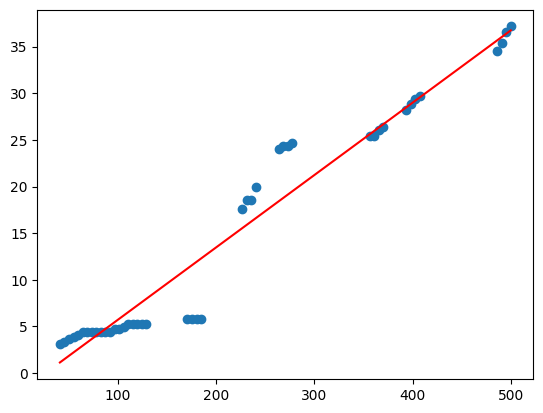

In [6]:
plt.scatter(data[:, 0], data[:, 1])
plt.plot(data[:, 0], model.c() * data[:, 0] + model.d(), color='red')
plt.show()